In [18]:
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from pprint import pprint
from IPython.display import clear_output
from random import sample

%matplotlib inline

## Downloading

In [2]:
with open('names.txt', 'r', encoding='utf-8') as file:
    names = file.read().split('\n')

In [3]:
print('Number of items:', len(names))

Number of items: 1493


In [4]:
pprint(names[:5])

['ЭПЛАРО 2-местный модульный диван, садовый',
 'СУННЕРСТА тележка',
 'ХЕМНЭС консольный стол',
 'ПОЭНГ кресло',
 'МИТТБИТ салфетка под приборы']


In [9]:
clean_names = [re.sub(r'[^А-Яа-я ]', '', name) for name in names]

Max length: 63


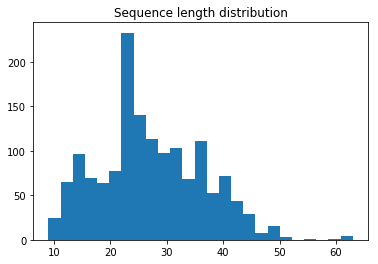

In [11]:
MAX_LENGTH = max(map(len, names))
print('Max length:', MAX_LENGTH)

plt.title('Sequence length distribution')
_ = plt.hist(list(map(len, names)), bins=25)

## Preprocessing

In [12]:
tokens = list(set(''.join(names)))
print('Size of alphabet:', len(tokens))

Size of alphabet: 81


In [13]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
PAD_IX = token_to_id[' ']

In [14]:
def to_matrix(lines, max_len=None, pad=PAD_IX, dtype='int32', batch_first=True):
    '''Casts a list of names into matrix with tokens id'''
    
    max_len = max_len or MAX_LENGTH
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix

In [15]:
# Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::500]))
print(to_matrix(names[::500]))

ЭПЛАРО 2-местный модульный диван, садовый
ДЮГРИП стакан
ИНДУСТРИЕЛЛ подвесной светильник
[[13 37 30 17 66 20 57 78 10 65 27 12 68 58 19 62 57 65 26 73 52 23  6 58
  19 62 57 73 63 50  1 58 59 57 12  1 73 26 50 19 62 57 57 57 57 57 57 57
  57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
 [51 79 28 66 49 37 57 12 68  1 67  1 58 57 57 57 57 57 57 57 57 57 57 57
  57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57
  57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
 [49 69 51 25 21 75 66 49 48 30 30 57 45 26 73 50 27 12 58 26 62 57 12 50
  27 68 63 23  6 58 63 67 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57
  57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]]


## Network

In [27]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens, embedding_size=16, rnn_num_units=64):
        super().__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, int64[batch_size]
        :param h_prev: previous rnn hidden states, float32 matrix [batch, rnn_num_units]
        """
        x_emb = self.embedding(x)
        h_next = self.rnn_update(torch.cat((h_prev, x_emb), dim=1))        
        h_next = torch.tanh(h_next)        
        logits = self.rnn_to_logits(h_next)        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units)

In [33]:
class Network:
    '''Wrapper class for a neural network, takes list of names as the only param'''
    def __init__(self, names):
        self.names = names
        self.MAX_LENGTH = max(map(len, names))
        self.tokens = list(set(''.join(names)))
        self.token_to_id = {token: idx for idx, token in enumerate(tokens)}
        self.PAD_IX = token_to_id[' ']
        
        self.rnn = CharRNNCell(len(self.tokens))
        
    def to_matrix(self, lines, max_len=None, dtype='int32', batch_first=True):
        '''Casts a list of names into matrix with tokens id'''

        max_len = max_len or self.MAX_LENGTH
        lines_ix = np.zeros([len(lines), max_len], dtype) + self.PAD_IX

        for i in range(len(lines)):
            line_ix = [token_to_id[c] for c in lines[i]]
            lines_ix[i, :len(line_ix)] = line_ix

        if not batch_first: # convert [batch, time] into [time, batch]
            lines_ix = np.transpose(lines_ix)

        return lines_ix
        
    def rnn_loop(self, batch_ix):
        """
        Computes log P(next_character) for all time-steps in lines_ix
        :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
        """
        batch_size, max_length = batch_ix.size()
        hid_state = self.rnn.initial_state(batch_size)
        logprobs = []

        for x_t in batch_ix.transpose(0, 1):
            hid_state, logp_next = self.rnn(x_t, hid_state)  # <-- here we call your one-step code
            logprobs.append(logp_next)

        return torch.stack(logprobs, dim=1)
    
    def train(self, num_epochs=1000):
        opt = torch.optim.Adam(self.rnn.parameters())
        history = []
        
        for i in range(num_epochs):
            batch_ix = self.to_matrix(sample(names, 32))
            batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

            logp_seq = self.rnn_loop(batch_ix)

            predictions_logp = logp_seq[:, :-1]
            actual_next_tokens = batch_ix[:, 1:]

            logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None])

            loss = -logp_next.mean()

            opt.zero_grad()
            loss.backward()
            opt.step()

            history.append(loss.data.numpy())
            if (i + 1) % 100 == 0:
                clear_output(True)
                plt.plot(history, label='loss')
                plt.legend()
                plt.show()
    
    def generate_sample(self, seed_phrase=' ', temperature=1.0):
        '''
        The function generates text given a phrase of length at least SEQ_LENGTH.
        :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
        :param max_length: maximum output length, including seed_phrase
        :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                            smaller temperature converges to the single most likely output
        '''

        x_sequence = [token_to_id[token] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        hid_state = self.rnn.initial_state(batch_size=1)

        #feed the seed phrase, if any
        for i in range(len(seed_phrase) - 1):
            hid_state, _ = self.rnn(x_sequence[:, i], hid_state)

        #start generating
        for _ in range(self.MAX_LENGTH - len(seed_phrase)):
            hid_state, logp_next = self.rnn(x_sequence[:, -1], hid_state)
            p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

            # sample next token and push it back into x_sequence
            next_ix = np.random.choice(len(self.tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

        return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

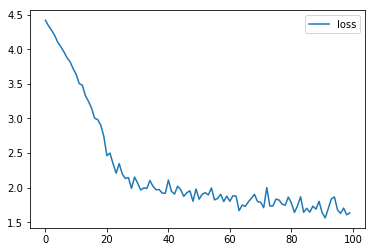

KeyboardInterrupt: 

In [34]:
rnn = Network(names)
rnn.train()

In [35]:
rnn.generate_sample()

'        ми жо     л3лау   о          Фрмке кебРтмылльг ке Ш    '

In [12]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

## Training loop

In [15]:
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

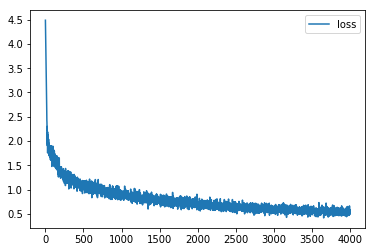

In [20]:
for i in range(2500, 4000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None])

    loss = -logp_next.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

## Main function

In [ ]:
def train

## Sampling

In [23]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [181]:
for _ in range(10):
    print(generate_sample(char_rnn, 'КТО'))

КТОЛГОВИК чКетном                                              
КТОВСЕКУБ-к столта                                             
КТОКСГОЛИС таругка                                             
КТОРСВА ГОСТА чехол д/1-местный голоткий довар                 
КТОВКНЕНТЁО 3 д/румик-крышка                                   
КТОФРАМЕ свелетеахи                                            
КТОКСОСТИГ скафья 4 осгиврми с 2 ящиками                       
КТОЛМОЛЬМЕ жклстейна с/17ртул                                  
КТОКСАННЭРЛА полка д/стска д/ножда для                         
КТОВСМУНС тусечки                                              
